In [ ]:
!pip install yfinance numpy pandas matplotlib statsmodels hmmlearn --quiet

# Undergoing a Regime Change

### Definition:
Regime-switching models are a class of statistical models that allow parameters to change over time based on unobserved (latent) states or regimes. These models are widely used in economics, finance, environmental science, and other fields to capture structural changes, cyclical behavior, or sudden shifts in data-generating processes. Markov-Switching Autoregressive (MSAR) is a very popular model to analyze regime switches in financial markets.

### Description

For this report, we will use the **MSAR model** (Markov Switching Autoregressive model) to understand regime switches in the S&P 500. This model is widely used in finance and economics to capture structural breaks, business cycles, and volatility regimes.

#### (A) Observable Equation (AR Process)

The observed time series $ y_t $ follows an autoregressive (AR) process, but its parameters depend on the hidden state $ S_t $:

$$
y_t = \mu_{S_t} + \phi_{1, S_t} y_{t-1} + \phi_{2, S_t} y_{t-2} + \cdots + \phi_{p, S_t} y_{t-p} + \sigma_{S_t} \epsilon_t
$$

where:

- $ S_t \in \{1, 2, \dots, K\} $ is the latent state at time $ t $
- $ \mu_{S_t} $: State-dependent mean
- $ \phi_{1, S_t}, \dots, \phi_{p, S_t} $: State-dependent AR coefficients
- $ \sigma_{S_t} $: State-dependent volatility
- $ \epsilon_t \sim \mathcal{N}(0, 1) $: Standard normal noise

### Demonstration and Diagram:
For Demonstration purposes we have used S&P 500 data extracted using yahoo finance for the period '1990-01-01' to '2025-03-28'.




[*********************100%***********************]  1 of 1 completed


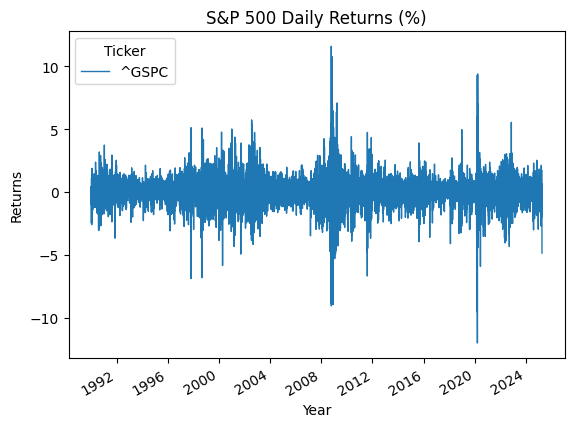

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download S&P 500 data
sp500 = yf.download('^GSPC', start='1990-01-01', end='2025-04-04')['Close']
returns = sp500.pct_change().dropna() * 100  # Percentage returns

returns.plot(
    linewidth=1,
    xlabel="Year",
    ylabel="Returns",
    title="S&P 500 Daily Returns (%)",
)
plt.show()

      lb_stat     lb_pvalue
10  95.745654  3.857216e-16


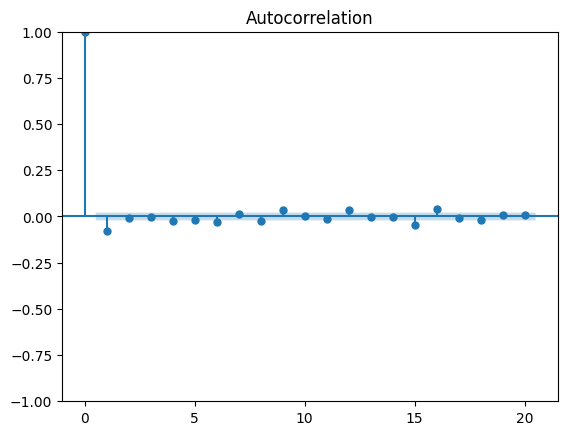

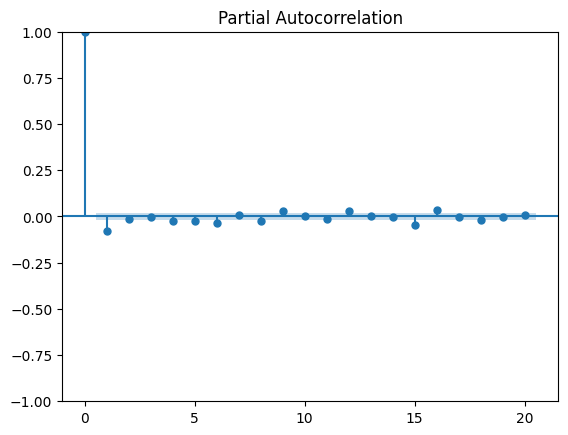

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plot ACF/PACF
plot_acf(returns, lags=20, alpha=0.05)
plot_pacf(returns, lags=20, alpha=0.05)

# Ljung-Box test
lb_test = acorr_ljungbox(returns, lags=[10], return_df=True)
print(lb_test)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


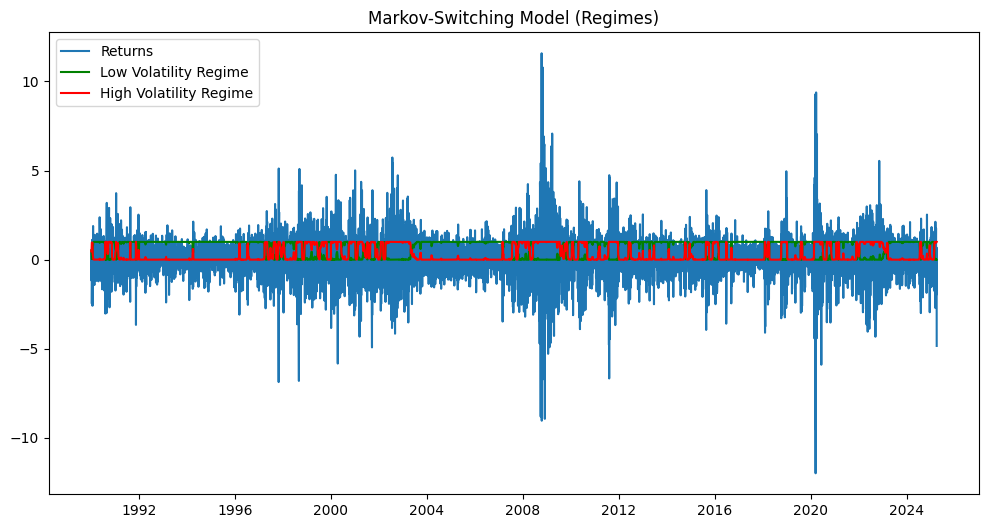

In [ ]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit a 2-regime Markov-switching autoregressive model
model_msm = MarkovRegression(returns, k_regimes=2, trend='c', switching_variance=True)
result_msm = model_msm.fit()

# Plot regimes
plt.figure(figsize=(12, 6))
plt.plot(returns, label='Returns')
plt.plot(result_msm.smoothed_marginal_probabilities[0], label='Low Volatility Regime', color='green')
plt.plot(result_msm.smoothed_marginal_probabilities[1], label='High Volatility Regime', color='red')
plt.title("Markov-Switching Model (Regimes)")
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

model = MarkovRegression(
    returns,
    k_regimes=2,
    trend='c',
    switching_variance=True
)
result = model.fit()
print(result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  ^GSPC   No. Observations:                 8879
Model:               MarkovRegression   Log Likelihood              -12092.862
Date:                Tue, 08 Apr 2025   AIC                          24197.724
Time:                        13:19:31   BIC                          24240.273
Sample:                             0   HQIC                         24212.212
                               - 8879                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0804      0.009      8.833      0.000       0.063       0.098
sigma2         0.4567      0.013     34.567      0.0

The output shows two key transition probabilities governing regime shifts:

1. p[0->0] = 0.9874
Meaning: Probability of staying in Regime 0 (Low Volatility) in the next period.

Value: 98.74% chance the market remains calm if it’s currently calm.

Statistical Significance:

Std Err: 0.002 → Highly precise estimate.

Z-score: 497.361 → Extremely significant (p < 0.001).

95% CI: [0.984, 0.991] → True probability lies in this range.

2. p[1->0] = 0.0291
Meaning: Probability of switching from Regime 1 (High Volatility) to Regime 0 in the next period.

Value: 2.91% chance a crisis ends and the market stabilizes in the next period.

Statistical Significance:

Std Err: 0.005 → Reliable estimate.

Z-score: 6.392 → Highly significant (p < 0.001).

95% CI: [0.020, 0.038] → True probability is between 2%–3.8%.

Figure1 represents the daily return for S&P500.Figure2 is a regime-switching plot from a Markov-Switching Model applied to financial returns for S&P 500.The Green line represents probability of being in the low-volatility regime which means market will be stable. The Red line depicts probability of being in the high volatility regime which means crises or turbulence times in the market.
For trading desk this help to give indication to Buy in low-volatility regimes, hedge in high-volatility regimes.
### Diagnosis
We need to Check if the model residuals behave like white noise (no autocorrelation, homoskedasticity).
Check if transition probabilities are stable over time.
Evaluate how well the model separates regimes.
Balance goodness-of-fit.
Validate regime persistence and transitions.
### Damage:
Incase Model mislabels noise as regimes, it will lead to a false "high volatility" regime signal and in turn could prompt premature exit from profitable positions.
Poorly estimated volatility regimes or transition probabilities can overestimate/underestimate Risk.
Overfitting (too many regimes) or underfitting (too few) can lead to Spurious regimes demand or  Missed regime shifts.
### Directions:
Test the model with unseen data.
Verify the regimes with known events.
Avoid Skipping the diagnostic as it turns MSM into a "black box" that risks capital, credibility, and compliance.
### Deployment:
Post all the checks and validation, this model can be used to provides an edge in regime-aware investing, hedging, and forecasting.


# Handling multicollinearity

### Definition:
Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated, meaning they contain overlapping information. This makes it difficult for the model to determine the individual effect of each variable, leading to unstable or unreliable coefficient estimates and reducing the model’s interpretability and predictive power. In mathematical terms, consider a linear regression model:
$$ y = \omega_1x_1 + \omega_2 x_2 + ... + \omega_nx_n + b $$
Multicollinearity arises when  $\exists i \ne j: Corr(x_i, x_j) \approx \pm 1$, where Corr denotes the correlation between two random variables. This near-linear dependence between features makes the model's coefficient estimation highly sensitive to small changes in the data.

### Description:
Multicollinearity increases the variance of the estimated coefficients, meaning the values they can take become more spread out and unstable (Kutner et al.). As a result, the estimates become less reliable, making it difficult to determine the true effect of individual predictors. This can lead to misleading interpretations, such as incorrect signs or magnitudes of the coefficients.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

### Demonstration and Diagram
A compelling way to demonstrate the effects of multicollinearity is by modeling S&P 500 returns using sector ETF returns as predictors (Sharpe). We use daily adjusted close prices for SPY and sector ETFs from Yahoo Finance (Yahoo Finance). Sector ETFs such as Technology (XLK), Industrials (XLI), and Energy (XLE) often exhibit a high degree of correlation, which creates an ideal setup to highlight the issue. To better visualize the impact of multicollinearity, I intentionally added two artificially constructed predictors — duplicates of XLK and XLE with slight noise — making them highly correlated with the originals. Without applying any preprocessing or regularization, I trained a linear regression model on this dataset. You can see a full description of the model in the Jupyter Notebook. The condition number of the design matrix is extremely high (1.57e+04), indicating numerical instability. The model coefficients are unusually large, with inflated standard errors. Small changes in the input data could lead to dramatically different coefficient estimates. This setup effectively demonstrates how multicollinearity can mislead interpretation, cause instability in estimation, and negatively affect out-of-sample predictive performance, even when in-sample metrics (like R²) seem acceptable. This setup effectively demonstrates how multicollinearity can mislead interpretation, cause instability in estimation, and negatively affect out-of-sample predictive performance, even when in-sample metrics (like R²) seem acceptable.

In [ ]:
tickers = {
    "SPY": "S&P 500",
    "XLK": "Technology",
    "XLE": "Energy",
    "XLI": "Industrials",
}

data = yf.download(list(tickers.keys()), start="2020-01-01", end="2021-01-01")["Close"]

returns = data.pct_change().dropna()
returns.columns = [f"{col}_ret" for col in returns.columns]
returns["XLK_dup"] = returns["XLK_ret"] * 0.95 + np.random.normal(0, 0.0001, len(returns))
returns["XLE_dup"] = returns["XLE_ret"] * 1.02 + np.random.normal(0, 0.0001, len(returns))


X = returns.drop(columns=["SPY_ret"])
y = returns["SPY_ret"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

[*********************100%***********************]  4 of 4 completed


Train model

In [ ]:
X_train_const = add_constant(X_train)
ols_model = OLS(y_train, X_train_const).fit()
X_test_const = add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_const)

print("\nOLS Validation Metrics:")
print("R²:", r2_score(y_test, y_pred_ols))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ols)))
ols_model.summary()


OLS Validation Metrics:
R²: 0.9458687881693701
RMSE: 0.0022653240800710166


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SPY_ret   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2536.
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          2.70e-175
Time:                        13:19:37   Log-Likelihood:                 893.90
No. Observations:                 201   AIC:                            -1776.
Df Residuals:                     195   BIC:                            -1756.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.180      0.239      -0.001       0.000
XLE_ret       -1.2339      2.313     -0.533      0.594      -5.795       3.328
XLI_ret        0.3368      0.019     17.890      0.000       0.300       0.374
XLK_ret        1.2043      1.875      0.642      0.522      -2.494       4.903
XLK_dup       -0.7397      1.973     -0.375      0.708      -4.631       3.152
XLE_dup        1.2398      2.268      0.547      0.585      -3.232       5.712
==============================================================================
Omnibus:                       12.529   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               22.145
Skew:                           0.309   Prob(JB):                     1.55e-05
Kurtosis:                       4.504   Cond. No.                     1.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Diagnosis:
To determine whether there really is a problem and where to look for it, first of all we will build a correlation matrix. This matrix shows whether there is a linear relationship between two variables.


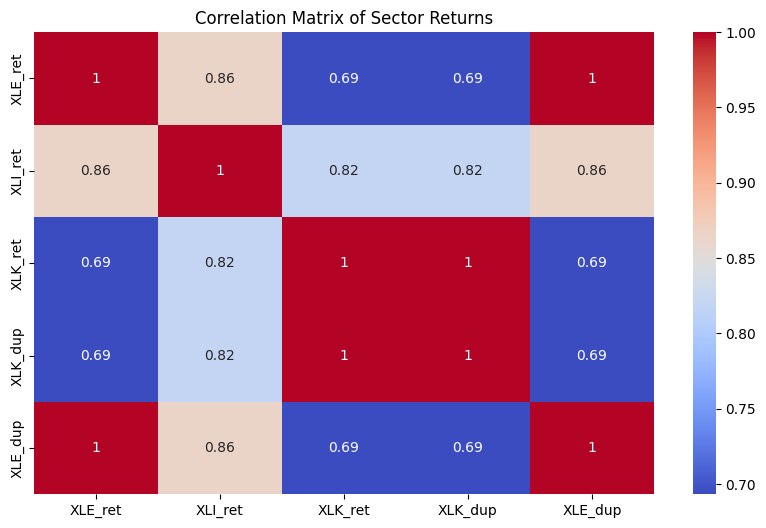

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Sector Returns")
plt.show()

To detect the issue, we compute the VIF (Variance Inflation Factor), which measures how much the variance of a regression coefficient is inflated due to multicollinearity with other predictors (Kutner et al.).


In [ ]:
vif = pd.DataFrame()
vif["Variable"] = X_train_const.columns
vif["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
print("VIF (Training Set):\n", vif)

VIF (Training Set):
   Variable            VIF
0    const       1.031826
1  XLE_ret  197218.976100
2  XLI_ret       6.291994
3  XLK_ret   64633.846010
4  XLK_dup   64560.245814
5  XLE_dup  197150.505748


### Damage:
Unstable coefficient estimates – Small changes in the data can lead to large swings in coefficients.
Incorrect signs or magnitudes – Coefficients may have signs that contradict theory or expectations.
Inflated standard errors – Makes it harder to identify statistically significant predictors.
Numerical instability – Can lead to problems during matrix inversion (e.g., large condition number).
Overfitting risk – Model may perform well in-sample but poorly out-of-sample.
### Directions:
To solve this problem, we can remove highly correlated features and retain only one of them, or we can create a new combined feature that captures their shared information — for example, by applying Principal Component Analysis (PCA) (James et al.).. We also can use some regularizations, for example, Ridge regression, to reduce coefficient values. Let’s drop the duplicated features and examine the results: the condition number decreased significantly (to 108), all coefficients are now below 1, and the standard errors are much smaller. This indicates that the model is more stable and better suited for reliable predictions. Also let’s estimate VIF factors:


In [ ]:
X_train_reduced = X_train.drop(columns=["XLK_dup", "XLE_dup"])
X_test_reduced = X_test.drop(columns=["XLK_dup", "XLE_dup"])
X_train_reduced_const = add_constant(X_train_reduced)
X_test_reduced_const = add_constant(X_test_reduced)

ols_reduced = OLS(y_train, X_train_reduced_const).fit()
y_pred_reduced = ols_reduced.predict(X_test_reduced_const)

print("\nReduced OLS (no XLF) Validation Metrics:")
print("R²:", r2_score(y_test, y_pred_reduced))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_reduced)))

ols_reduced.summary()


Reduced OLS (no XLF) Validation Metrics:
R²: 0.945532920766685
RMSE: 0.002272341029528212


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SPY_ret   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     4261.
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          7.88e-179
Time:                        13:19:38   Log-Likelihood:                 893.68
No. Observations:                 201   AIC:                            -1779.
Df Residuals:                     197   BIC:                            -1766.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.207      0.229      -0.001       0.000
XLE_ret        0.0308      0.010      2.984      0.003       0.010       0.051
XLI_ret        0.3369      0.019     17.991      0.000       0.300       0.374
XLK_ret        0.5011      0.013     39.023      0.000       0.476       0.526
==============================================================================
Omnibus:                       11.740   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.404
Skew:                           0.311   Prob(JB):                     6.12e-05
Kurtosis:                       4.389   Cond. No.                         108.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
vif_reduced = pd.DataFrame()
vif_reduced["Variable"] = X_train_reduced_const.columns
vif_reduced["VIF"] = [variance_inflation_factor(X_train_reduced_const.values, i) for i in range(X_train_reduced_const.shape[1])]
print("\nVIF After Removing duplicates:\n", vif_reduced)


VIF After Removing duplicates:
   Variable       VIF
0    const  1.028601
1  XLE_ret  3.967837
2  XLI_ret  6.274671
3  XLK_ret  3.054961


### Deployment:
The cleaned and stable model can be used to predict returns. It’s suitable for Portfolio allocation,  Risk monitoring or Trading signal generation. With multicollinearity removed, the model provides more reliable and interpretable predictions, making it ready for use in daily market analysis or automated pipelines.


# **Modeling non-stationarity and finding an equilibrium.**

In [ ]:
!pip install arch
from arch.unitroot import ADF, KPSS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen


### Definition:
A non-stationarity time series is a series which does not have constant mean and variance. A non-stationary time series has long term trends, seasonality and often has a unit root of the characteristic equation. If the two or more non stationary series are cointegrated then in the long term they move together even if in the short term they may deviate from each other. This is called mean reversion property or finding an equilibrium.

### Description:
The two non stationary time series are said to be cointegrated if there is a linear combination of two which makes the relationship stationary. Now, there are two ways to model such datasets. First, make both of the time series stationary with differencing and building a VAR model. Second, using cointegration and building ECM or VECM models. Both ECM and VECM have an error correction term that will measure the deviation from mean and adjust the future values to reach equilibrium.


For demonstration, we used real world data of five stocks, Vanguard Information Technology Index Fund ETF (VGT), Crude Oil May 25 (CL=F), Goldman Sachs Physical Gold ETF (AAAU), Walmart Inc. (WMT) and NIFTY 50 (^NSEI) from 1st Jan 2020 to 7th April 2025. The above figure shows the time plot of the stock price of five stocks. From the graph, the stock prices show an upward trend with some high variance time sections. When building a VAR model, we made all the time series stationary using 2nd order differencing and used the  differenced time series as input to the model.  From the model summary we got a lag of six as optimum value and used it to fit the VAR(6) model. One can find all the variable equations and significant variables from the model in the accompanied python file. Next, we build the ECM model using first order differenced time series of VGT and ^NSEI (still all non stationary) as input to the model. We checked their cointegration using the EG Test for Cointegration. In the Phillips and Ouliaris method and the table (PO test), we got p value less than critical value so cointegration is present. From the results, we can see all coefficient estimates are significant and lambda, Λ is VGT.L1 = -1.1918. Then from the Durbin-Watson test, we found no autocorrelation among residuals. See accompanied python file for detailed analysis.

In [ ]:
# Define the stock ticker for our dataset
stock_ticker = ['VGT','CL=F','AAAU', '^NSEI','WMT']

# Getting historical stock data
stock_data = yf.download(stock_ticker, start="2020-01-02", end="2025-04-07")
stock_close = stock_data['Close']

[*********************100%***********************]  5 of 5 completed


In [ ]:
stock_close.head()

Ticker,AAAU,CL=F,VGT,WMT,^NSEI
Date,,,,,
2020-01-02,15.25,61.180000,239.190262,36.681843,12282.200195
2020-01-03,15.45,63.049999,236.676971,36.358013,12226.650391
2020-01-06,15.62,63.270000,237.463547,36.284008,11993.049805
2020-01-07,15.68,62.700001,237.434753,35.947834,12052.950195
2020-01-08,15.56,59.610001,239.938507,35.824474,12025.349609


In [ ]:
stock_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1363 entries, 2020-01-02 to 2025-04-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAAU    1322 non-null   float64
 1   CL=F    1323 non-null   float64
 2   VGT     1322 non-null   float64
 3   WMT     1322 non-null   float64
 4   ^NSEI   1301 non-null   float64
dtypes: float64(5)
memory usage: 63.9 KB


In [ ]:
# Imputing missing values in dataset with previous day closing prices
for cols in stock_close.columns:
  stock_close[cols] = stock_close[cols].fillna(method='ffill')


<ipython-input-22-819afc3d224e>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_close[cols] = stock_close[cols].fillna(method='ffill')
<ipython-input-22-819afc3d224e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close[cols] = stock_close[cols].fillna(method='ffill')


In [ ]:
stock_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1363 entries, 2020-01-02 to 2025-04-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAAU    1363 non-null   float64
 1   CL=F    1363 non-null   float64
 2   VGT     1363 non-null   float64
 3   WMT     1363 non-null   float64
 4   ^NSEI   1363 non-null   float64
dtypes: float64(5)
memory usage: 63.9 KB


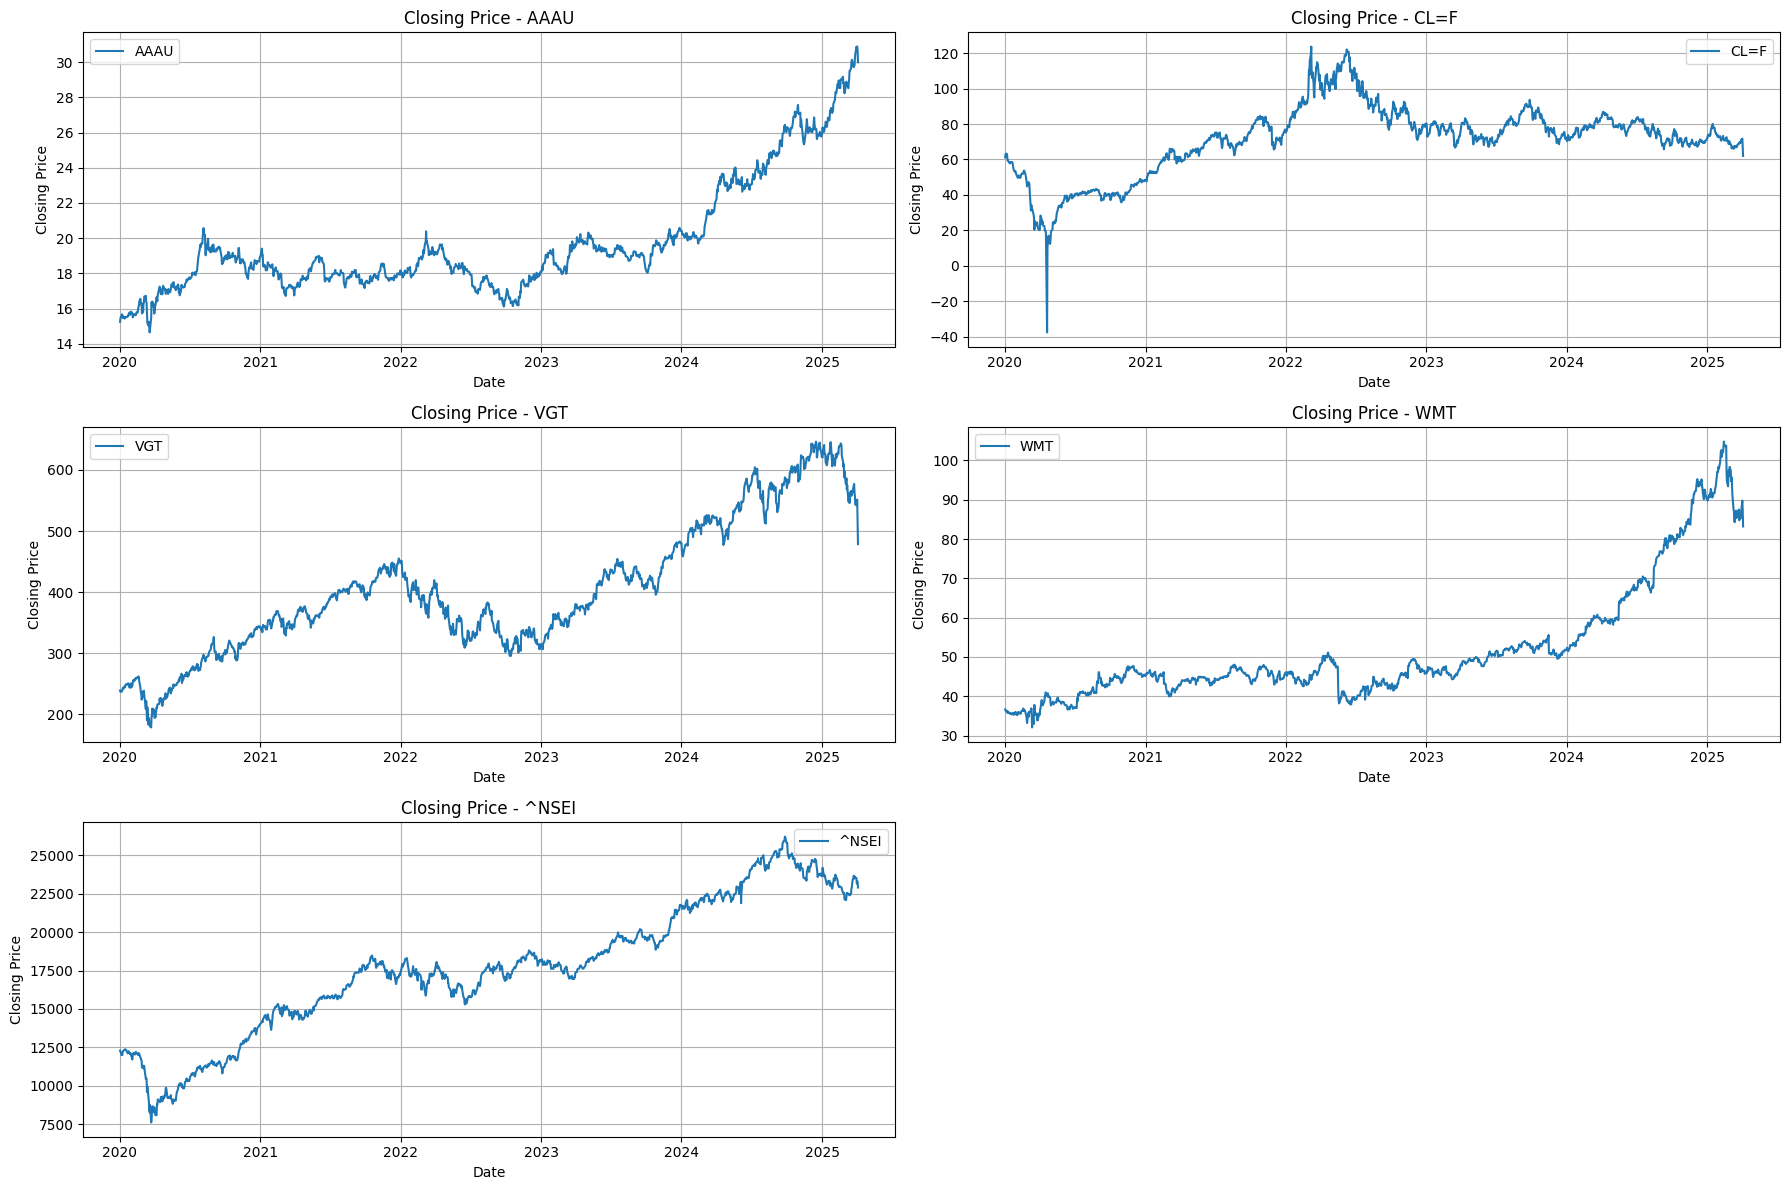

In [ ]:
# Plotting charts for stocks
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each stock's closing price in a separate subplot
for i, column in enumerate(stock_close.columns):
    axes[i].plot(stock_close.index, stock_close[column], label=column)
    axes[i].set_title(f'Closing Price - {column}')  # Set individual subplot titles
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Closing Price')
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots (if the number of stocks is less than 9)
for i in range(len(stock_close.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
# Stock_Close dataset, ADF Test with Drift and without Trend
for col in stock_close.columns:
  adf_drift = ADF(stock_close[col], trend="c", method="bic")
  print(col,"Augmented Dickey-Fuller Unit Root Test\n", adf_drift.regression.summary())
  print("\nTest statistics and critical values: \n", adf_drift, "\n")

AAAU Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6511
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.420
Time:                        13:19:49   Log-Likelihood:                 332.21
No. Observations:                1362   AIC:                            -660.4
Df Residuals:                    1360   BIC:                            -650.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L

In [ ]:
# Stock_Close dataset, KPSS Test
for col in stock_close.columns:
  kpss_test = KPSS(stock_close[col], trend="ct", lags=-1)
  print(col, kpss_test.summary(), "\n")

AAAU     KPSS Stationarity Test Results   
Test Statistic                  1.014
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

CL=F     KPSS Stationarity Test Results   
Test Statistic                  0.973
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

VGT     KPSS Stationarity Test Results   
Test Statistic                  0.689
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


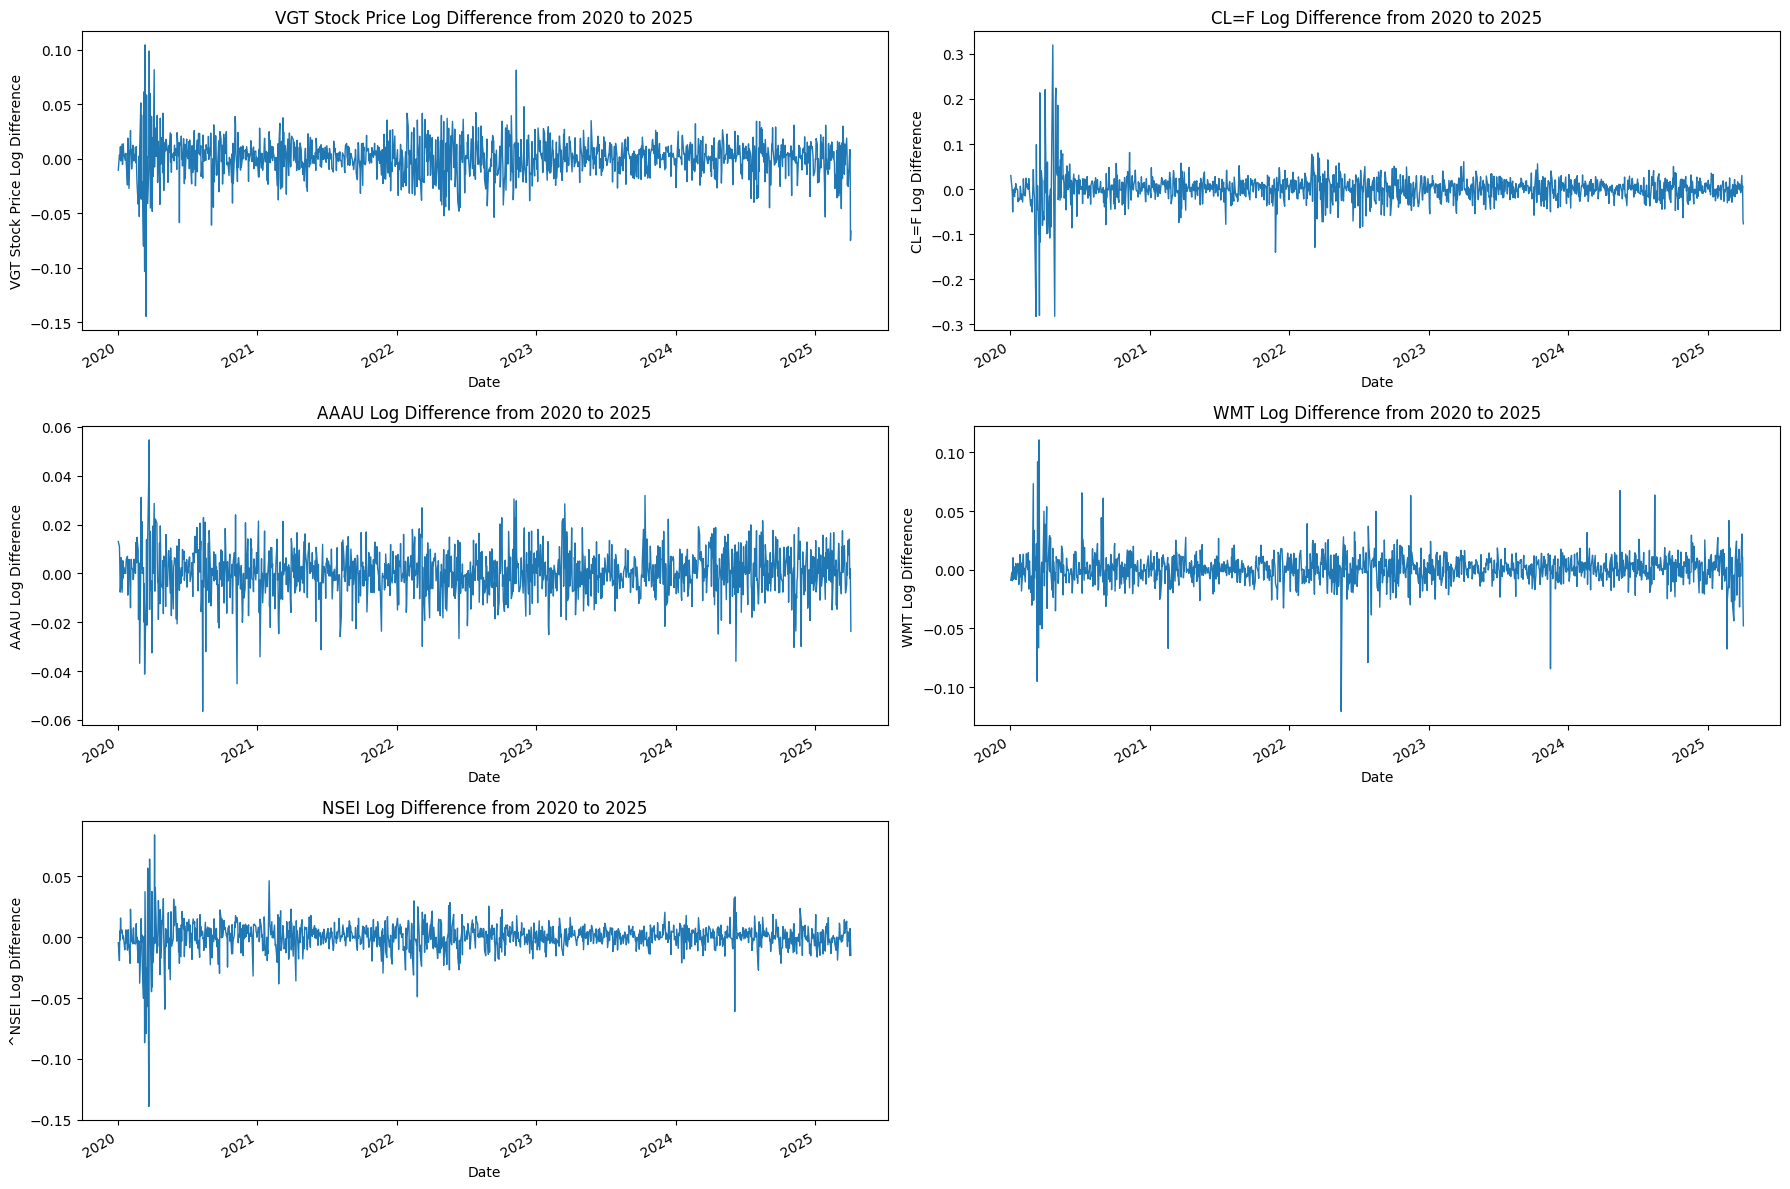

In [ ]:
# Time Plots for Differenced Stocks in our dataset
fig, axs = plt.subplots(3, 2, figsize=(18, 12))

lvgt = np.log(stock_close['VGT']).diff().dropna()
lvgt.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="VGT Stock Price Log Difference",
    title="VGT Stock Price Log Difference from 2020 to 2025",
    ax=axs[0, 0],
)

lclf = np.log(stock_close['CL=F']).diff().dropna()
lclf.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="CL=F Log Difference",
    title="CL=F Log Difference from 2020 to 2025",
    ax=axs[0, 1],
)

laaau = np.log(stock_close['AAAU']).diff().dropna()
laaau.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="AAAU Log Difference",
    title="AAAU Log Difference from 2020 to 2025",
    ax=axs[1, 0],
)

lwmt = np.log(stock_close['WMT']).diff().dropna()
lwmt.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="WMT Log Difference",
    title="WMT Log Difference from 2020 to 2025",
    ax=axs[1, 1],
)

lnsei = np.log(stock_close['^NSEI']).diff().dropna()
lnsei.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="^NSEI Log Difference",
    title="NSEI Log Difference from 2020 to 2025",
    ax=axs[2, 0],
)

axs[2, 1].axis("off")
fig.tight_layout()
plt.show()

In [ ]:
# ADF Test Results with 5% Significance Level for Differenced Dataset
lvgt_adf = ADF(stock_close['VGT'], trend="n", method="bic")
lclf_adf = ADF(stock_close['CL=F'], trend="n", method="bic")
laaau_adf = ADF(stock_close['AAAU'], trend="n", method="bic")
lwmt_adf = ADF(stock_close['WMT'], trend="n", method="bic")
lnsei_adf = ADF(stock_close['^NSEI'], trend="n", method="bic")


pd.DataFrame(
    {
        "VGT Stock Price": (lvgt_adf.stat, lvgt_adf.critical_values["5%"]),
        "| CL=F Price": (lclf_adf.stat, lclf_adf.critical_values["5%"]),
        "| AAAU Price": (laaau_adf.stat, laaau_adf.critical_values["5%"]),
        "| Walmart Stock Price": (lwmt_adf.stat, lwmt_adf.critical_values["5%"]),
        "| NSEI Stock Price": (lnsei_adf.stat, lnsei_adf.critical_values["5%"]),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

,VGT Stock Price,| CL=F Price,| AAAU Price,| Walmart Stock Price,| NSEI Stock Price
ADF Test Statistic,0.566711,-0.482304,2.208091,1.616911,1.463680
5% Critical Value,-1.941199,-1.941199,-1.941199,-1.941199,-1.941199


In [ ]:
# 2nd difference of Dataset, since previous one did not remove non stationary

lvgt2 = lvgt.diff().dropna()

lclf2 = lclf.diff().dropna()

laaau2 = laaau.diff().dropna()

lwmt2 = lwmt.diff().dropna()

lnsei2 = lnsei.diff().dropna()

# ADF Test Results with 5% Significance Level for Differenced Dataset
lvgt2_adf = ADF(lvgt2, trend="n", method="bic")
lclf2_adf = ADF(lclf2, trend="n", method="bic")
laaau2_adf = ADF(laaau2, trend="n", method="bic")
lwmt2_adf = ADF(lwmt2, trend="n", method="bic")
lnsei2_adf = ADF(lnsei2, trend="n", method="bic")


pd.DataFrame(
    {
        "VGT Stock Price": (lvgt2_adf.stat, lvgt2_adf.critical_values["5%"]),
        "| CL=F Price": (lclf2_adf.stat, lclf2_adf.critical_values["5%"]),
        "| AAAU Price": (laaau2_adf.stat, laaau2_adf.critical_values["5%"]),
        "| Walmart Stock Price": (lwmt2_adf.stat, lwmt2_adf.critical_values["5%"]),
        "| NSEI Stock Price": (lnsei2_adf.stat, lnsei2_adf.critical_values["5%"]),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)





,VGT Stock Price,| CL=F Price,| AAAU Price,| Walmart Stock Price,| NSEI Stock Price
ADF Test Statistic,-17.414250,-20.992302,-19.724355,-18.497483,-21.657585
5% Critical Value,-1.941201,-1.941201,-1.941201,-1.941201,-1.941200


In [ ]:
# Now all Time Series in dataset is Stationary
# Join log time series in one DataFrame
diff_data = pd.concat([lvgt2, lclf2, laaau2, lwmt2, lnsei2], axis=1)
diff_data.isnull().sum()

,0
VGT,0
CL=F,2
AAAU,0
WMT,0
^NSEI,0


In [ ]:
# Removin null rows
diff_data = diff_data.dropna(subset=["CL=F"])
diff_data.isnull().sum()

,0
VGT,0
CL=F,0
AAAU,0
WMT,0
^NSEI,0


In [ ]:
# VAR Model Lag Selection for 2nd Differenced Dataset

# Fit VAR model and run lag selection tool
model = VAR(diff_data)
x = model.select_order(maxlags=12, trend="c")
x.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-38.25,-38.23,2.456e-17,-38.24
1,-39.98,-39.86,4.356e-18,-39.93
2,-40.54,-40.33,2.472e-18,-40.46
3,-40.96,-40.65,1.624e-18,-40.85
4,-41.18,-40.77,1.312e-18,-41.02
5,-41.34,-40.83,1.118e-18,-41.15
6,-41.46,-40.86*,9.902e-19,-41.23
7,-41.52,-40.83,9.265e-19,-41.26
8,-41.64,-40.85,8.241e-19,-41.34
9,-41.66,-40.77,8.113e-19,-41.32


In [ ]:
# We get Six and Twelve lags as optimal choice
# We build VAR(6) model with 6 lags
# VAR(1) model for Differenced GOOGLE, EURUSD, UST10Y
diff_mod = VAR(diff_data)
diff_mod_var = diff_mod.fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic="bic",  # ic=None => automatic lag selection
    method="ols",
    trend="c",
    verbose=True,
)
diff_mod_var.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 18, BIC -> 6, FPE -> 18, HQIC ->  11>
Using 6 based on bic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Apr, 2025
Time:                     13:19:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -40.8780
Nobs:                     1353.00    HQIC:                  -41.2513
Log likelihood:           18613.6    FPE:                9.72142e-19
AIC:                     -41.4748    Det(Omega_mle):     8.68037e-19
--------------------------------------------------------------------
Results for equation VGT
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.000073         0.000500            0.147           0.883
L1.VGT          -0.893936         0.030498          -29.311           0.000
L1.CL=F         -0.007615         0.015214           -0.501           0.617
L1.AAA

In [ ]:
# Get the lag order that was selected
lag_order = diff_mod_var.k_ar
print(lag_order)

6


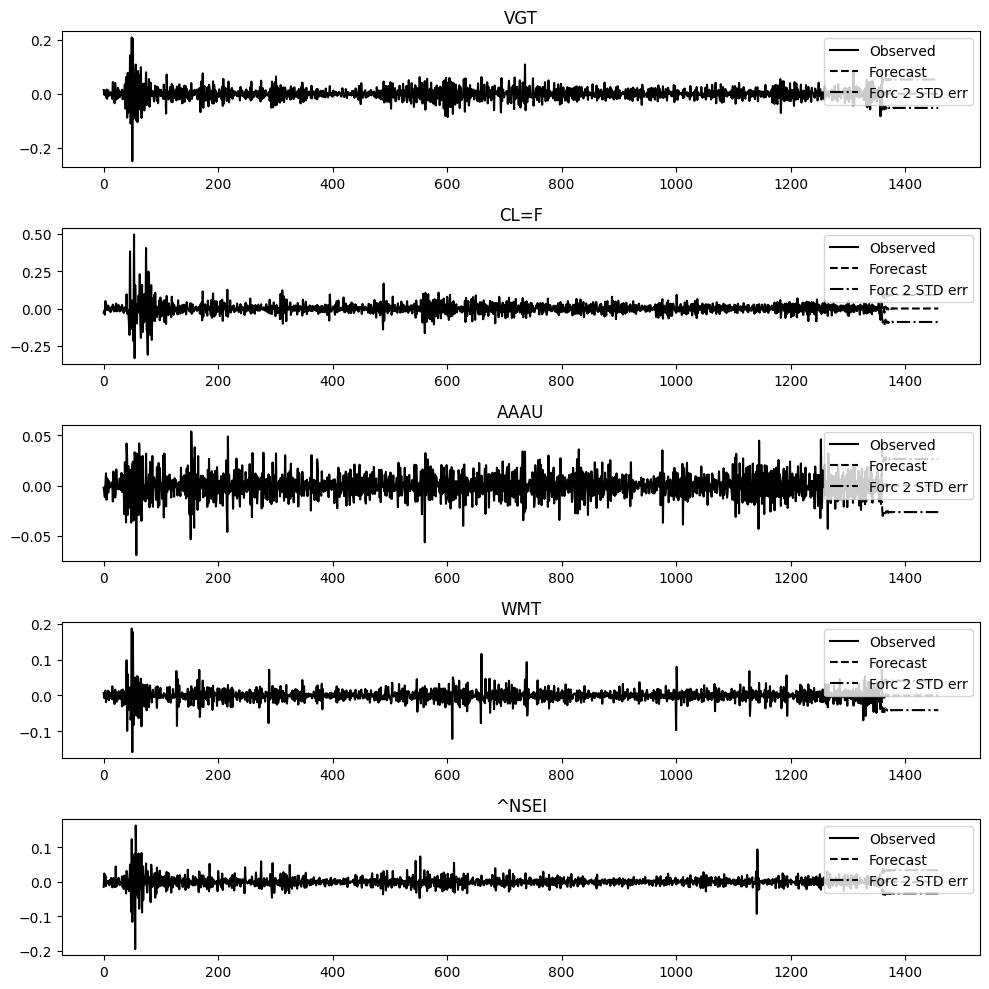

In [ ]:
# VAR Model Forecast of the Difference of the Differenced Dataset
diff_mod_var.plot_forecast(steps=100, alpha=0.05, plot_stderr=True)
plt.tight_layout()
plt.show()

In [ ]:
# Now we build ERROR CORRECTION MODEL for dataset ' stock_close' which has all non stationary time series
# From the time plots of VGT and ^NSEI, they seem to move together so we select these for analysis

# Two-Step Residual Based Test for Cointegration for lvgt and lnsei (log difference of VGT and ^NSEI) as both are I(1)
# (aka Phillips and Ouliaris cointegration test)
print(
    phillips_ouliaris(
        lvgt, lnsei, trend="c", test_type="Za", kernel="bartlett"
    )
)

Phillips-Ouliaris Za Cointegration Test
Statistic: -1531.7150578258804
P-value: 0.0
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 18.834
Trend: c
Distribution Order: 3


In [ ]:
# p-value is less than 0.05 critical value. Hence, lvgt and lnsei are cointegrated
# Error Correction Model Result for lvgt and lnsei
ecm_model = UECM(
    endog=pd.DataFrame(lvgt),
    lags=1,
    exog=pd.DataFrame(lnsei),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

                              UECM Model Results                              
Dep. Variable:                  D.VGT   No. Observations:                 1362
Model:                     UECM(1, 1)   Log Likelihood                3644.977
Method:               Conditional MLE   S.D. of innovations              0.024
Date:                Tue, 08 Apr 2025   AIC                          -7279.953
Time:                        13:20:06   BIC                          -7253.873
Sample:                             1   HQIC                         -7270.190
                                 1362                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.063      0.288      -0.000       0.001
VGT.L1        -1.1918      0.028    -42.809      0.000      -1.246      -1.137
^NSEI.L1       0.3150      0.061      5.185      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Durbin-Watson Test Result for ECM of lvgt and lnsei
print(durbin_watson(ecm_model.fittedvalues))

2.437202576678295


### Diagnosis:
In the VAR model, check for stationarity of time series using ADF and KPSS test.
In ECM model, check for cointegration using EG test for cointegration and Phillips and Ouliaris method and the table (PO test).
Then using  the Durbin-Watson test, Check if the model residuals behave like white noise (no autocorrelation, homoscedasticity)
Evaluate model parameters like AIC, BIC, lambda, coefficient of variables ,goodness of fit etc.

### Damage:
Since the underlying statistics like mean and variance are not constant over time, you cannot fit a regression line, and the forecast will have unreliable results as previous data can be significantly different from present or future data.
Like regression, one cannot do statistical inferences like hypothesis testing reliably because no constant mean and variance violates the assumptions required.
Another problem is there is no easy or simpler model present to model multiple non-stationarity time series. We need models like VAR which requires stationary time series or ECM and VECM models which can tackle non stationary time series directly.
### Directions:
Try different transformation techniques like log transformation, squared or box-cox transformation which can make the series stationary then build VAR model
Tty differencing (1st order, 2nd order) which can remove non-stationary from trends and seasonality for VAR model.
Use models like ECM and VECM, which takes care of non-stationarity by using cointegration of underlying variables. There are state space models which are dynamic and take care of all types non-stationary but are complex to implement. In the python file we used ECM model with 1st order differencing because it has lowest aic.
Check the forecast values with the actual unseen data to see model performance.
We can use RNN and Deep learning techniques to model non stationary time series.

### Deployment:
Both VAR and ECM models can be used to forecast future stock prices and ECM models particularly can measure the deviation in one stock relative to deviation in other stock . It is useful in pairs trading and finding equilibrium in the long run.
